# Tweet Classification Analysis

## Integrantes:

* Del Villar, Javier
* Otrino, Facundo Damián
* Pistoya, Haydeé Soledad
* Rojas, Mariano Arturo
* Sorza, Andrés
* Vaillard, Leandro Carlos

## Cargamos Librerías

In [1]:
from tqdm import tqdm
import emoji
import nltk
import pandas as pd
import re
import spacy
import numpy as np

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

nlp = spacy.load("es_core_news_lg")
spanish_stops = set(nltk.corpus.stopwords.words('spanish'))
tqdm.pandas()

## Cargamos dataset

El dataset contiene tweets clasificados:

In [2]:
data = pd.read_csv('classified_tweets.csv')

print(f'El dataset tiene {data.shape[0]} tweets!')

data.head()

El dataset tiene 155399 tweets!


,created_at,month,id,full_text,place_name,full_text_SE,full_text_CE,full_text_CE_EC,full_text_clasif,full_text_SE_clasif,full_text_CE_clasif,full_text_CE_EC_clasif
0,2020-01-30 21:01:21+00:00,2020-01,1222988192024088578,Hay alguna indicación sobre las precauciones q...,Ciudad Autónoma de Buenos Aires,Hay alguna indicación sobre las precauciones q...,Hay alguna indicación sobre las precauciones q...,Hay alguna indicación sobre las precauciones q...,3,3,3,3
1,2020-02-10 03:57:33+00:00,2020-02,1226716810839560192,en dos años ya nadie se va a acordar de estos ...,Ciudad Autónoma de Buenos Aires,en dos años ya nadie se va a acordar de estos ...,en dos años ya nadie se va a acordar de estos ...,en dos años ya nadie se va a acordar de estos ...,1,1,1,1
2,2020-02-26 02:13:31+00:00,2020-02,1232488835855998976,Interesante artículo sobre el Coronavirus... h...,Choya,Interesante artículo sobre el Coronavirus... h...,Interesante artículo sobre el Coronavirus... h...,Interesante artículo sobre el Coronavirus... h...,3,3,3,3
3,2020-02-26 22:39:04+00:00,2020-02,1232797255608029185,Lo que hubiera sido el sketch del cuñado de ma...,Corrientes,Lo que hubiera sido el sketch del cuñado de ma...,Lo que hubiera sido el sketch del cuñado de ma...,Lo que hubiera sido el sketch del cuñado de ma...,1,1,1,1
4,2020-02-06 13:38:16+00:00,2020-02,1225413401532403715,Quien le teme al Coronavirus ?? https://t.co/0...,El Calafate,Quien le teme al Coronavirus ?? https://t.co/0...,Quien le teme al Coronavirus ?? https://t.co/0...,Quien le teme al Coronavirus ?? https://t.co/0...,1,1,1,1


Descartamos columnas innecesarias:

In [3]:
data = data.drop(columns=['created_at', 'id', 'full_text_SE', 'full_text_CE', 'full_text_CE_EC', 'full_text_clasif', 'full_text_SE_clasif', 'full_text_CE_EC_clasif'])

data.head()

,month,full_text,place_name,full_text_CE_clasif
0,2020-01,Hay alguna indicación sobre las precauciones q...,Ciudad Autónoma de Buenos Aires,3
1,2020-02,en dos años ya nadie se va a acordar de estos ...,Ciudad Autónoma de Buenos Aires,1
2,2020-02,Interesante artículo sobre el Coronavirus... h...,Choya,3
3,2020-02,Lo que hubiera sido el sketch del cuñado de ma...,Corrientes,1
4,2020-02,Quien le teme al Coronavirus ?? https://t.co/0...,El Calafate,1


Reclasificamos las clases a tres categorías:

In [4]:
data['full_text_CE_clasif'] = pd.Categorical(data['full_text_CE_clasif'].replace({1: 'neg', 2: 'neg', 3: 'neu', 4: 'pos', 5: 'pos'}))

data.head()

,month,full_text,place_name,full_text_CE_clasif
0,2020-01,Hay alguna indicación sobre las precauciones q...,Ciudad Autónoma de Buenos Aires,neu
1,2020-02,en dos años ya nadie se va a acordar de estos ...,Ciudad Autónoma de Buenos Aires,neg
2,2020-02,Interesante artículo sobre el Coronavirus... h...,Choya,neu
3,2020-02,Lo que hubiera sido el sketch del cuñado de ma...,Corrientes,neg
4,2020-02,Quien le teme al Coronavirus ?? https://t.co/0...,El Calafate,neg


In [5]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Extractor de Emojis
    def emojis_extractor(text):
        a = " ".join(c for c in text if c in emoji.UNICODE_EMOJI['es']).split()
        for i in a:
            try:
                text = text.replace(i, ' ')
            except:
                pass
        return text.lower()
    nuevo_texto = emojis_extractor(texto)
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+|www\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\“\\”\\‘]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub('\d+', ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 2]
    # Stopwords
    nuevo_texto = [x for x in nuevo_texto if x not in spanish_stops]
    # Lematización
    nuevo_texto = nlp(" ".join(nuevo_texto))
    nuevo_texto = str(" ".join([t.lemma_ for t in nuevo_texto]))
    
    return nuevo_texto

In [ ]:
data['full_text_clean'] = data['full_text'].progress_apply(limpiar_tokenizar)
data

In [18]:
palabras = pd.Series([y for x in data.full_text_clean.values.flatten() for y in x.split()]).value_counts()

In [19]:
palabras[:50]

coronavirus      59204
covid            47745
caso             22721
nuevo            14258
argentino        14031
hacer            12651
él                9932
poder             9273
día               8647
decir             7660
ir                7644
positivo          7497
pandemio          7261
hoy               7181
salud             6527
seguir            6331
dar               5572
vacuna            5490
provincia         5426
persona           5344
año               5332
país              5258
ser               4996
ahora             4739
gobierno          4698
contagio          4601
️                 4506
gente             4502
querer            4359
muerte            4347
ciudad            4264
cuarentén         4143
pasar             4116
cuarentena        4082
ver               4069
buen              4053
total             3948
morir             3754
primero           3584
quedateencasa     3523
diario            3503
salir             3466
confirmar         3408
infobae    

In [23]:
data['is_coronavirus'] = data['full_text_clean'].str.contains('coronavirus|covid|virus|pandemio', regex=True)

data['is_Argentina'] = data['full_text_clean'].str.contains('argentino|gobierno|poder|país|provincia|ciudad', regex=True)

data['is_cuarentena'] = data['full_text_clean'].str.contains('cuarentén|cuarentena', regex=True)

data['is_muerte'] = data['full_text_clean'].str.contains('muerte|morir|fallecido', regex=True)

data['is_vacuna'] = data['full_text_clean'].str.contains('vacuna')

data['is_casos'] = data['full_text_clean'].str.contains('caso|positivo', regex=True)

data['is_quedateencasa'] = data['full_text_clean'].str.contains('quedateencasa')

data.head()

,month,full_text,place_name,full_text_CE_clasif,full_text_clean,is_coronavirus,is_Argentina,is_cuarentena,is_muerte,is_vacuna,is_casos,is_quedateencasa
0,2020-01,Hay alguna indicación sobre las precauciones q...,Ciudad Autónoma de Buenos Aires,neu,alguno indicación precaución tomar coronavirus,True,False,False,False,False,False,False
1,2020-02,en dos años ya nadie se va a acordar de estos ...,Ciudad Autónoma de Buenos Aires,neg,dos año nadie acordar chino infierno parasite ...,True,False,False,False,False,False,False
2,2020-02,Interesante artículo sobre el Coronavirus... h...,Choya,neu,interesante artículo coronavirus,True,False,False,False,False,False,False
3,2020-02,Lo que hubiera sido el sketch del cuñado de ma...,Corrientes,neg,ser sketch cuñado macri buscar publico coronav...,True,False,False,False,False,False,False
4,2020-02,Quien le teme al Coronavirus ?? https://t.co/0...,El Calafate,neg,temer coronavirus,True,False,False,False,False,False,False


In [24]:
data.to_csv('analyzed_tweets.csv')

## Nube de Palabras

In [4]:
# data = pd.read_csv('analyzed_tweets.csv')
# data.head()

,Unnamed: 0,month,full_text,place_name,full_text_CE_clasif,full_text_clean,is_coronavirus,is_Argentina,is_cuarentena,is_muerte,is_vacuna,is_casos,is_quedateencasa
0,0,2020-01,Hay alguna indicación sobre las precauciones q...,Ciudad Autónoma de Buenos Aires,neu,alguno indicación precaución tomar coronavirus,True,False,False,False,False,False,False
1,1,2020-02,en dos años ya nadie se va a acordar de estos ...,Ciudad Autónoma de Buenos Aires,neg,dos año nadie acordar chino infierno parasite ...,True,False,False,False,False,False,False
2,2,2020-02,Interesante artículo sobre el Coronavirus... h...,Choya,neu,interesante artículo coronavirus,True,False,False,False,False,False,False
3,3,2020-02,Lo que hubiera sido el sketch del cuñado de ma...,Corrientes,neg,ser sketch cuñado macri buscar publico coronav...,True,False,False,False,False,False,False
4,4,2020-02,Quien le teme al Coronavirus ?? https://t.co/0...,El Calafate,neg,temer coronavirus,True,False,False,False,False,False,False


In [17]:
texto_wordcloud = " ".join([str(t) for t in data['full_text_clean']])

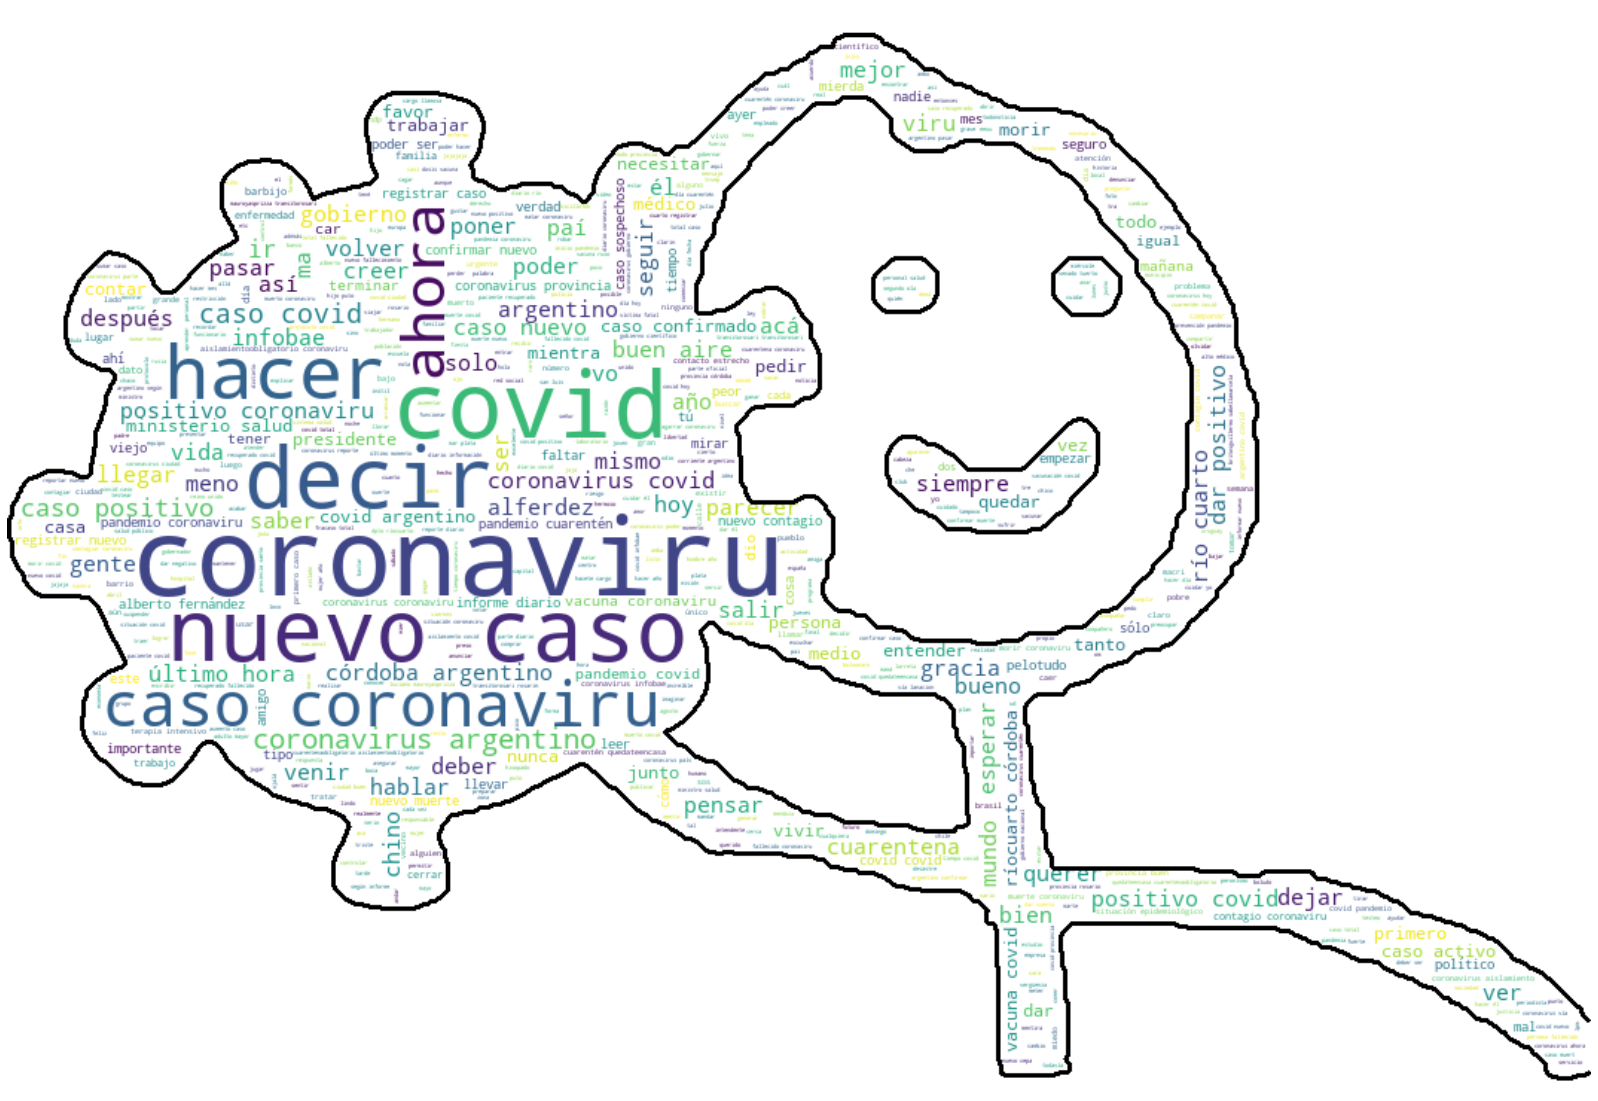

In [16]:
covid_mask = np.array(Image.open('covid.png'))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_covid_mask = np.ndarray((covid_mask.shape[0],covid_mask.shape[1]), np.int32)

for i in range(len(covid_mask)):
    transformed_covid_mask[i] = list(map(transform_format, covid_mask[i]))

wc = WordCloud(background_color="white", max_words=1000, mask=transformed_covid_mask, contour_width=3, contour_color='black')

wc.generate(texto_wordcloud)

plt.figure(figsize=[30,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()